## Install Relevant Libraries

In [ ]:
!pip install datasets
!pip install mistralai
!pip install rouge

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

## Load MusicPile Dataset into a dataframe

In [3]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("m-a-p/MusicPile-sft")
p_df = pd.DataFrame(list(pd.DataFrame(ds)["train"]))

## Basic Filtering

In [4]:
def process_text(text):
  if text.startswith("Human: "):
    text = text[7:]
  if text.startswith("Assistant: "):
    text = text[11:]
  text = text.replace("</s>", "")
  text = text.strip()
  return text

filtered_source_pdf = p_df[p_df.src != "distilled"]
filtered_source_pdf["instruction"] = filtered_source_pdf["instruction"].apply(process_text)
filtered_source_pdf["output"] = filtered_source_pdf["output"].apply(process_text)
filtered_source_pdf["input"] = filtered_source_pdf["input"].apply(process_text)

<ipython-input-4-76e1e5634caf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_source_pdf["instruction"] = filtered_source_pdf["instruction"].apply(process_text)
<ipython-input-4-76e1e5634caf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_source_pdf["output"] = filtered_source_pdf["output"].apply(process_text)
<ipython-input-4-76e1e5634caf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [5]:
# Remove Empty Values

filtered_source_pdf = filtered_source_pdf[filtered_source_pdf["instruction"] != ""]
filtered_source_pdf = filtered_source_pdf[filtered_source_pdf["input"] != ""]
filtered_source_pdf = filtered_source_pdf[filtered_source_pdf["output"] != ""]

# Only outputs containing ABC Notation
filtered_source_pdf = filtered_source_pdf[(filtered_source_pdf["output"].str.contains("X:"))]

## Filtering by Tasks

### Find Samples that align with the finetuning tasks

#### Here is a list of finetuning tasks:
1. Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt. Develop a series of chord pairings that amplify the harmonious elements in the given music piece. Design a fitting succession of chords that blend well with the provided musical score.
2. Craft musical works that follow the given chord alterations. Construct musical creations that adhere to the set chord modifications. Develop a musical piece using the given chord progression.
3. Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order. Craft a piece of music that integrates both the suggested theme and letter-based structure. Develop a musical piece employing the provided motif and an alphabet-based structure.
4.

In [6]:
# prompt: Function to check rouge score between two strings
from rouge import Rouge

rouge = Rouge()
def get_rouge_l_f_score(hypothesis, reference):
  scores = rouge.get_scores(hypothesis.lower(), reference.lower())
  return scores[0]["rouge-l"]['r']

hypothesis = "This is a sample hypothesis."
reference = "This is a sample reference."

get_rouge_l_f_score(hypothesis, reference)

0.8

In [ ]:
filtered_source_pdf["rogue_harmonize"] = filtered_source_pdf.apply(lambda x: get_rouge_l_f_score(x["instruction"], "Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt. Develop a series of chord pairings that amplify the harmonious elements in the given music piece. Design a fitting succession of chords that blend well with the provided musical score."), axis=1)
filtered_source_pdf = filtered_source_pdf.sort_values(by="rogue_harmonize", ascending=False)
rogue_harmonize = filtered_source_pdf[(filtered_source_pdf["output"].str.contains("X:"))][:2000]
rogue_harmonize

In [ ]:
filtered_source_pdf["rogue_chord_conditioned"] = filtered_source_pdf.apply(lambda x: get_rouge_l_f_score(x["instruction"], "Craft musical works that follow the given chord alterations. Construct musical creations that adhere to the set chord modifications. Develop a musical piece using the given chord progression"), axis=1)

,instruction,input,output,src,id,rogue_harmonize,rogue_chord_conditioned
1067631,Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt.,|: dcAG F2 DF | E2 CE FDFA | dcAG F2 DF | Add^c defe | dcAG F2 DF | \n EDCE FDD^c | dcAG FDDF |1 Add^c d4 :|2 Add^c d3 e |]: f2 fe fagf | \n ecgc acgc | fede fagf | edce d^cde | f2 fe fagf | ecgc acgc | \n fedf edcB |1 Add^c d3 e :|2 Add^c d4 |],"X:1\nL:1/8\nM:4/4\nK:Dmin\n|:""Dm"" dcAG F2 DF |""C"" E2 CE""Dm"" FDFA | dcAG F2 DF |""Gm"" Add^c""A"" defe |""Dm"" dcAG F2 DF | \n""C"" EDCE""Dm"" FDD^c | dcAG""Bb"" FDDF |1""Am"" Add^c""Dm"" d4 :|2""A7"" Add^c""Dm"" d3 e |]:""Dm"" f2 fe fagf | \n""C"" ecgc acgc |""Dm"" fede fagf |""Am"" edce""Dm"" d^cde |""Dm"" f2 fe fagf |""C"" ecgc acgc | \n""Dm"" fedf""Bb"" edcB |1""Am"" Add^c""Dm"" d3 e :|2""A7"" Add^c""Dm"" d4 |]",https://huggingface.co/datasets/sander-wood/irishman,1067631,1.0,0.15
880108,Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt.,"Bc | d2 fd cdBd | AdFd EecA | d2 fd""^(Bm)"" cdAF | GEec d2 :| fg | \n afdf afba | gfed cdef | gfed cbag | fedc d2 || fg | afdf afba | \n gfed cBAG | FAdc Bbag | fedc d2 |]","X:1\nL:1/8\nM:2/2\nK:D\n Bc |""D"" d2 fd cdBd |""D"" AdFd""A"" EecA |""D"" d2 fd""^(Bm)"" cdAF |""A7"" GEec""D"" d2 :| fg | \n""D"" afdf afba |""Em"" gfed""A"" cdef |""A7"" gfed cbag |""A7"" fedc""D"" d2 || fg |""D"" afdf afba | \n""Em"" gfed""A"" cBAG |""D"" FAdc""G"" Bbag |""A7"" fedc""D"" d2 |]",https://huggingface.co/datasets/sander-wood/irishman,880108,1.0,0.15
357337,Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt.,|: B>c BA G2 Bd | g2 gB d2 d2 |1 f2 fe c2 c2 | e2 ed B2 G2 :|2 f2 fe dc BA | \n G2 B2 G4 :: e2 ef g2 fe | dB GB d2 d2 |1 cA FA c2 c2 | B2 GB d2 d2 :|2 \n f2 fe dc BA | G2 B2 G4 :|,"X:1\nL:1/8\nM:4/4\nK:G\n|:""G"" B>c BA G2 Bd | g2 gB d2 d2 |1""D7"" f2 fe c2 c2 | e2 ed""G"" B2 G2 :|2""D7"" f2 fe dc BA | \n""G"" G2 B2 G4 ::""C"" e2 ef g2 fe |""G"" dB GB d2 d2 |1""D7"" cA FA c2 c2 |""G"" B2 GB d2 d2 :|2 \n""D7"" f2 fe dc BA |""G"" G2 B2 G4 :|",https://huggingface.co/datasets/sander-wood/irishman,357337,1.0,0.15
991927,Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt.,"EGBE G3 B | A3 G FGAF | EGBE G3 B | AGFA BEED :: EGBE c3 d | \n BBBG AGFG | EGBE c3 d | BAGB A4 :: FGBF GBFG | EFGE FGEF | \n DFAD FADF | AGFG E2 z2 :|[K:D]""^Arr. 2"" BdfB d2 df | eeed cdec | \n BdfB d2 df | edcd B2 a2 :: BdfB g2 ge | f2 fa fefd | \n BdfB g2 ge | fedf e2 a2 :: cdfc dfcd | BcdB cdBc | AceA ceAc | \n edcd B2 a2 :|","X:1\nL:1/8\nM:2/2\nK:G\n""Em"" EGBE""G"" G3 B |""D"" A3 G FGAF |""Em"" EGBE""G"" G3 B |""D"" AGFA""Em"" BEED ::""Em"" EGBE""C"" c3 d | \n""G"" BBBG""D"" AGFG |""Em"" EGBE""C"" c3 d |""G"" BAGB""D"" A4 ::""Bm"" FGBF GBFG |""Em"" EFGE FGEF | \n""D"" DFAD FADF |""D"" AGFG""Em"" E2 z2 :|[K:D]""^Arr. 2""""Bm"" BdfB d2 df |""A"" eeed cdec | \n""Bm"" BdfB""D"" d2 df |""A"" edcd""Bm"" B2 a2 ::""Bm"" BdfB""G"" g2 ge |""D"" f2 fa""A"" fefd | \n""Bm"" BdfB""G"" g2 ge |""D"" fedf""A"" e2 a2 ::""F#m"" cdfc dfcd |""Bm"" BcdB cdBc |""A"" AceA ceAc | \n""A"" edcd""Bm"" B2 a2 :|",https://huggingface.co/datasets/sander-wood/irishman,991927,1.0,0.15
1007055,Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt.,ed |: ^cAGA ED^CD | EAAG ABcd | e2 a2 gage | dBAG E2 ed | ^cAGA ED^CD | EAAG ABcd | \n e2 a2 gage |1 cABG A2 ed :|2 cABG A2 AB || cege c'ege | cege aege | \n cege c'ege | (3gag ed cAGA | cege c'ege | cege ae g2 | (3c'ag ea gedg | \n edBG EGed ||,"X:1\nL:1/8\nM:4/4\nK:C\n ed |:""A"" ^cAGA ED^CD | EAAG ABcd |""C"" e2 a2 gage | dBAG E2 ed |""A"" ^cAGA ED^CD | EAAG ABcd | \n""C"" e2 a2""G"" gage |1""A"" cABG A2 ed :|2""A"" cABG A2 AB ||""C"" cege c'ege | cege""G"" aege | \n""C"" cege c'ege | (3gag ed""G"" cAGA |""C"" cege c'ege | cege ae g2 |""Am"" (3c'ag ea""E"" gedg | \n edBG EGed ||",https://huggingface.co/dataset

In [ ]:
filtered_source_pdf["rogue_alpha_motif_conditioned"] = filtered_source_pdf.apply(lambda x: get_rouge_l_f_score(x["instruction"], "Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order. Craft a piece of music that integrates both the suggested theme and letter-based structure. Develop a musical piece employing the provided motif and an alphabet-based structure."), axis=1)

In [ ]:
filtered_source_pdf["rogue_max_conditioned"] = filtered_source_pdf.apply(lambda x: max(x["rogue_alpha_motif_conditioned"], x["rogue_chord_conditioned"]) , axis=1)

In [ ]:
filtered_source_pdf["rogue_combined_conditioned"] = filtered_source_pdf.apply(lambda x: get_rouge_l_f_score(x["instruction"], "Craft musical works that follow the given chord alterations. Construct musical creations that adhere to the set chord modifications. Develop a musical piece using the given chord progressionDevelop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order. Craft a piece of music that integrates both the suggested theme and letter-based structure. Develop a musical piece employing the provided motif and an alphabet-based structure."), axis=1)

In [ ]:
filtered_source_pdf = filtered_source_pdf.sort_values(by="rogue_max_conditioned", ascending=False)

In [ ]:
# filtered_source_pdf[10000:10010]
# best 10000
rogue_conditioned = filtered_source_pdf[:10000]
# oversampled_rogue_chord_conditioned = filtered_source_pdf[1400:6400]
rogue_conditioned

,instruction,input,output,src,id,rogue_harmonize,rogue_chord_conditioned,rogue_form_analysis,rogue_motif_analysis,rogue_alpha_motif_conditioned,rogue_max_conditioned,rogue_combined_conditioned
859928,Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order.,"ABA';X:1\nL:1/8\nM:2/4\nK:G\n['d2 Bd BA/G/ Bd', '(3GAG (.d.B)', 'g2 dB']",X:1\nL:1/8\nM:2/4\nK:G\n e | d2 Bd | BA/G/ Bd | Bd (c/B/)A/G/ | cAAe | d2 Bd | BA/G/ Bd | Bdce | dGG :: A | (3GAG (.d.B) | \n e>cd>B | (3GAG (.d.B) | c<AA>B | (3GAG (.d.B) | ecdc | Bdce | dGG :: d | g2 dB | g2 dB | g2 dB | \n cAAf | g2 dB | g2 dB | Bdce | dGG :|,https://huggingface.co/datasets/sander-wood/irishman,859928,0.250000,0.30,0.111111,0.090909,0.500000,0.50,0.365854
137693,Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order.,"AA';X:1\nL:1/8\nM:2/4\nK:Ador\n['e2 a2', 'A2 A2']",X:1\nL:1/8\nM:2/4\nK:Ador\n e2 a2 | g2 a>g | e>f g>e | d2 f2 | e2 a2 | g>a g>f | e>d c>d | A4 :| A2 A2 | c2 c>B | A>c B>A | \n G>F G2 | A2 A2 | c>A c>d | e>d c>d | A4 :|,https://huggingface.co/datasets/sander-wood/irishman,137693,0.250000,0.30,0.111111,0.090909,0.500000,0.50,0.365854
1087285,Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order.,A;X:1\nL:1/16\nQ:1/4=100\nM:4/4\nK:D\n['cB2c A2=cB2=c[dG-]G GGFE B2A2 ^cdG2 GGEC'],X:1\nL:1/16\nQ:1/4=100\nM:4/4\nK:D\n z4 z dd2 cB2c2<d2A- | Add2 cB2c AF2<D2dd2 | cB2c2<d2A2dd2 cB2c | A2=cB2=c[dG-]G GGFE B2A2 | \n ^cdG2 GGEC D4- Ddd2 | cB2c2<d2A2dd2 cB2c | AF2<D2dd2 cB2c2<d2A- | Add2 cB2c A2=cB2=c[dG-]G | \n GGFE B2A2 ^cdG2 GGEC | D3F2DG2 E^G2E A2E^A- | AEB2 =A=GFE2<D2F2DG2 | E^G2E A2E^A2EB2 =A=GFE | \n D4- Ddd2 cB2c2<d2A- | Add2 cB2c AF2<D2dd2 | cB2c2<d2A2dd2 cB2c | A2=cB2=c[dG-]G GGFE B2A2 | \n ^cdG2 GGEC D4- Ddd2 | cB2c2<d2A2dd2 cB2c | AF2<D2dd2 cB2c2<d2A- | Add2 cB2c A2=cB2=c[dG-]G | \n GGFE B2A2 ^cdG2 GGEC | D3F2DG2 E^G2E A2E^A- | AEB2 =A=GFE2<D2F2DG2 | E^G2E A2E^A2EB2 =A=GFE | D2 |],https://huggingface.co/datasets/sander-wood/irishman,1087285,0.250000,0.30,0.111111,0.090909,0.500000,0.50,0.365854
382259,Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order.,"AB;X:1\nL:1/8\nQ:1/8=180\nM:4/4\nK:G\n['d edBA G3 A B2 Ac BE', 'dedc BGBd']",X:1\nL:1/8\nQ:1/8=180\nM:4/4\nK:G\n d | edBA G3 A | B2 Ac BE E2 | GFGE DEGA | BGdB A3 d | edBA G3 A | B2 Ac BE E2 | GFGE DEGA | \n dBAc BGG :| z | dedc BGBd | e2 af gfge | dedc BGBd | egfa g3 g | dedc BGBd | e2 af gfge | \n d2 df e2 eg | fgaf g3 :|,https://huggingface.co/datasets/sander-wood/irishman,382259,0.250000,0.30,0.111111,0.090909,0.500000,0.50,0.365854
985886,Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order.,"AB;X:1\nL:1/8\nM:4/4\nK:C\n['cAA A2', 'aga bag aec Ace dBG EGB']","X:1\nL:1/8\nM:4/4\nK:C\n[M:6/8][K:D] Tea e uce ve e!p!ace""^K:D""""^K:A""[Q:1/8=160]""^A modal"" .e | cAA A2 A | EAB cBA | \n BGG G2 G | BGB gdB | cAA A2 B | cde agf | gec Bed | cAA A2 :| e | aga bag | aec Ace | dBG EGB | \n Acf efg | aga bag | aec Ace | dBG EGB | cAA A2 :|",https://huggingface.co/datasets/sander-wood/irishman,985886,0.250000,0.30,0.111111,0.090909,0.500000,0.50,0.365854
...,...,...,...,...,...,...,...,...,...,...,...,...
535993,Develop a musical piece that combines the given theme and letter-structured outline.,"AB;X:1\nL:1/8\nQ:1/2=80\nM:2/2\nK:A\n['a2 ec', 'E2 efec dB TB2 dBbd cA TA2']",X:1\nL:1/8\nQ:1/2=80\nM:2/2\nK:A\n a2 ec dfBd | ceAc BE E2 | a2 ec f3 a | gfe^d e2 E2 :: efec dB TB2 | dBbd cA TA2 | a2 ec B3 f | \n edcB A4 :|,https://huggingface.co/datasets/sander-wood/irishman,535993,0.083333,0.35,0.148148,0.181818,0.300000,0.35,0.219512
979737,Develop a musical work that adheres to the given framework and maintains the standardized conventions of the genre.,"'Binary', 'Sectional: Verse/Chorus'","X:1\nL:1/8\nM:9/8\nK:G\n""Dm"" D2 A A2 G""Am"" ABc |""Dm"" D2 A A2

In [ ]:
filtered_source_pdf = filtered_source_pdf.sort_values(by="rogue_chord_conditioned", ascending=False)

In [ ]:
# filtered_source_pdf[(~filtered_source_pdf["instruction"].str.contains("motif") & (filtered_source_pdf["instruction"].str.contains("chord"))) & (filtered_source_pdf["input"].str.contains("', '"))][10000:10010]
# best 10000
rogue_chord_conditioned = filtered_source_pdf[(~filtered_source_pdf["instruction"].str.contains("motif") & (filtered_source_pdf["instruction"].str.contains("chord"))) & (filtered_source_pdf["input"].str.contains("', '"))][:10000]
# oversampled_rogue_chord_conditioned = filtered_source_pdf[1400:6400]
rogue_chord_conditioned

,instruction,input,output,src,id,rogue_harmonize,rogue_chord_conditioned,rogue_form_analysis,rogue_motif_analysis,rogue_alpha_motif_conditioned,rogue_max_conditioned,rogue_combined_conditioned
779540,Construct musical creations that adhere to the set chord modifications.,"'G', 'C', 'G', 'D7', 'G', 'Am', 'D7', 'G', 'G', 'D7', 'G', 'C', 'G', 'D7', 'G', 'D7', 'G', 'Am', 'D7', 'G', 'G', 'D7', 'G', 'C', 'G', 'D7', 'G', 'D', 'Em', 'D', 'C', 'D7', 'G'","X:1\nL:1/8\nM:6/8\nK:G\n D |""G"" G2 A B2 c | dgd Bcd |""C"" cBA""G"" BAG |""D7"" FAA A2 B |""G"" G2 A B2 c | dgd Bcd | \n""Am"" cBc""D7"" Adc |""G"" BGG G2 :| f |""G"" g3""D7"" def |""G"" gdc BAG |""C"" cBA""G"" BAG |""D7"" FAA A2 f | \n""G"" g3""D7"" def |""G"" gdc BAG |""Am"" cBc""D7"" Adc |""G"" BGG G2 |] f |""G"" g3""D7"" def |""G"" gdc BAG | \n""C"" cBA""G"" BAG |""D7"" FAA A2 a |""G"" bag""D"" agf |""Em"" gfe""D"" def |""C"" gfe""D7"" def |""G"" gdB G2 |]",https://huggingface.co/datasets/sander-wood/irishman,779540,0.166667,0.50,0.037037,0.090909,0.133333,0.50,0.243902
383108,Construct musical creations that adhere to the set chord modifications.,"'Bm', 'A', 'Bm', 'Em', 'A', 'Bm', 'F#m', 'A', 'G', 'D', 'A', 'F#m7', 'F#m7', 'Bm', 'Bm', 'A', 'D', 'A', 'Bm', 'F#m7', 'A', 'Bm', 'A', 'D', 'A', 'Bm', 'A', 'F#m7', 'Bm', 'Bm', 'A', 'D', 'A', 'Bm', 'F#m7', 'A', 'Gmaj7', 'F#m7', 'E', 'D', 'F#m7', 'Bm'","X:1\nL:1/8\nM:4/4\nK:Bmin\n""Bm"" B2""A"" c/B/A""Bm"" BF F2 |""Em"" EFAB""A"" ceae |""Bm"" f B B2 FBBc |""F#m"" Acef""A"" c2 BA | \n Bb""G""bB""D"" a2 fe |""A"" cfec""F#m7"" ecAc | B""F#m7"" F2 F ABce | f2 ec""Bm"" B2 BA :| \n""Bm"" FB B2""A"" Ac c2 |""D"" d2 fd""A"" eAcA |""Bm"" FB(3:2:1B(3:2:1B(3:2:1B FBBc |""F#m7"" Acef""A"" c2 BA | \n""Bm"" FB B2""A"" ABc |""D"" d2 fd""A"" eAcA | B2""Bm"" fB""A"" ecAB |""F#m7"" BAdc""Bm"" B2 BA | \n""Bm"" FBBB""A"" Ac c2 |""D"" d2 fd""A"" eAcA |""Bm"" F B2 FBBc |""F#m7"" Acef""A"" c2 ba | \n""Gmaj7"" bfab""F#m7"" efaf |""E"" eAcd""D"" dcBA |""F#m7"" BF F2 ABcf | f2 ec""Bm"" B3 z ||",https://huggingface.co/datasets/sander-wood/irishman,383108,0.166667,0.50,0.037037,0.090909,0.133333,0.50,0.243902
291818,Construct musical creations that adhere to the set chord modifications.,"'Bb', 'F', 'F7', 'Bb', 'Eb', 'Bb', 'Gm', 'F7', 'Bb', 'F', 'Bb7', 'Eb', 'Bb', 'F7', 'Bb'","X:1\nL:1/8\nQ:1/4=100\nM:6/8\nK:Bb\n""Bb"" FFF FGA | B3 F3 |""F"" AAA""F7"" ABc |""Bb"" B3- B2 z |""Eb"" GGG BAG |""Bb"" F3 B3 |""Gm"" BBB BAB | \n""F7"" c3- c2 z ||""Bb"" d3- d_d=d | B3 F3 | dcB BAB |""F"" c3- c2 z |""Bb7"" ddd""Eb"" cBG |""Bb"" F3 B3 | \n""F7"" AAA ABc |""Bb"" B3- B2 z |]",https://huggingface.co/datasets/sander-wood/irishman,291818,0.166667,0.50,0.037037,0.090909,0.133333,0.50,0.243902
175219,Construct musical creations that adhere to the set chord modifications.,"'A', 'E', 'A', 'E', 'A', 'E', 'A', 'E', 'A', 'A', 'D', 'E', 'A', 'E', 'A', 'A', 'D', 'E', 'A', 'E', 'A'","X:1\nL:1/8\nQ:1/8=200\nM:2/2\nK:A\n""A"" cBAB cBAB | cBAG""E"" F2 E2 |""A"" cBAB cBAB | c e2 c""E"" B2 AB |""A"" cBAB cBAB | cBAG""E"" F2 E2 | \n""A"" c e2 c BAGA |""E"" BA G2""A"" A4 ::""A"" [ee]4 [ce]2 A2 |""D"" F3 A""E"" BABc |""A"" [ee]4 [ce]2 A2 | \n""E"" FEFG""A"" A4 |""A"" [ee]4 [ce]2 A2 |""D"" F3 E""E"" FGAB |""A"" c e2 c BAGA |""E"" BA G2""A"" A4 :|",https://huggingface.co/datasets/sander-wood/irishman,175219,0.166667,0.50,0.037037,0.090909,0.133333,0.50,0.243902
191911,Construct musical creations that adhere to the set chord modifications.,"'D', 'Em', 'G', 'Em', 'A7', 'D', 'D', 'A7', 'D', 'A', 'D', 'A7', 'D', 'A', 'D'","X:1\nL:1/8\nM:3/4\nK:D\n dc BA |""D"" F2 FE DE | F2 dc BA | F2 FE DF |""Em"" G3 FGA |""G"" B2 BA GF |""Em"" E3 FGA | \n""A7"" BA Bc BA |1""D"" F2 :|2""D"" d2 |: DF Ad |""A7"" c2 cB AB |""D"" DF BF AF |""A"" EA Ec Ec | \n""D"" d2 DF Ad |""A7"" c2 cB AB |""D"" DF BF AF |""A"" EA Ec Ec |""D"" d2 :|",https://huggingface.co/datasets/sander-wood/irishman,191911,0.166667,0.50,0.037037,0.090909,0.133333,0.50,0.243902
...,...,...,...,...,...,...,...,...,...,...,...,...
1085966,Create musical co

In [ ]:
filtered_source_pdf = filtered_source_pdf.sort_values(by="rogue_alpha_motif_conditioned", ascending=False)

In [ ]:
filtered_source_pdf[20000:20010]
# best 20000
rogue_alpha_motif_conditioned = filtered_source_pdf[filtered_source_pdf["instruction"].str.contains("motif")][:20000]
# oversampled_rogue_chord_conditioned = filtered_source_pdf[1400:6400]
rogue_alpha_motif_conditioned

,instruction,input,output,src,id,rogue_harmonize,rogue_chord_conditioned,rogue_form_analysis,rogue_motif_analysis,rogue_alpha_motif_conditioned,rogue_max_conditioned,rogue_combined_conditioned
282211,Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order.,A;X:1\nL:1/8\nQ:1/8=232\nM:4/4\nK:G\n['dc BA'],X:1\nL:1/8\nQ:1/8=232\nM:4/4\nK:G\n|: DG BG EG cE | FA dc BA GF | EG cE DG BG | AB AG GF ED | DG BG EG cE | FA dc BA GF | \n E2 cA FD dc | B2 G2 G2 Bc | dc Bc dB ed | cB AB cA dc | BA GA BG cB | AB ^cA d2 B=c | \n dc Bc dB ed | cB AB cA dc | BA GF E2 cA | FD EF G2 :|,https://huggingface.co/datasets/sander-wood/irishman,282211,0.250000,0.30,0.111111,0.090909,0.500000,0.500000,0.365854
332964,Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order.,"AB;X:1\nL:1/8\nM:4/4\nK:C\n['D GAG GBd gfe dBG AGA BGD', 'def gag fed']",X:1\nL:1/8\nM:4/4\nK:C\n[M:6/8][K:G] .abc D | GAG GBd | gfe dBG | AGA BGD | EFE E2 D | GAG GBd | gfe dBG | AGA BGD | \n E2 F G2 :| B | def gag | fed edB | def gag | fed e2 B | def gag | fed gfe | dBG GBd | gfe dBG | \n AGA BGD | EFE E2 D | GAG GBd | gfe dBG | AGA BGD | E2 F G2 |],https://huggingface.co/datasets/sander-wood/irishman,332964,0.250000,0.30,0.111111,0.090909,0.500000,0.500000,0.365854
529415,Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order.,"AA'AA'';X:1\nL:1/8\nM:4/4\nK:D\n['A2 FB ABdf edfe fddB A2 FA', ':|2 AFEG FD D2', 'BAdA Beed cA A2 |1 FAdA BAdF']",X:1\nL:1/8\nM:4/4\nK:D\n A2 FB ABdf | edfe fddB | A2 FA ABdB |1 AFEG FDDB :|2 AFEG FD D2 |: FAdA BAdA | (3Bcd ed cAAG | \n FAdA BAdB |1 AFEG FDDG :|2 AFEG FD D2 || A2 FA ABdf | edfd edBd | A2 FA ABdB |1 AFEG FDDB :|2 \n AFEG FD D2 |: FAdA BAdA | Beed cA A2 |1 FAdA BAdF | GFEG FD D2 :|2 FAAc BAdB | AFEG FD D2 ||,https://huggingface.co/datasets/sander-wood/irishman,529415,0.250000,0.30,0.111111,0.090909,0.500000,0.500000,0.365854
235438,Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order.,"AB;X:1\nL:1/16\nM:2/4\nK:F\n['f2>c2{e} dcde', 'Afca cagf']","X:1\nL:1/16\nM:2/4\nK:F\n (3cde | f2>c2{e} dcde | f2>c2{e} dcde | f2a2g2c'2 | a>bg>a fcde | f2>c2{e} dcde | f2>c2{e} dcde | \n face AcFA | GFGA F2 |] !fermata!cB | Afca cagf | dgdb dbag | Afca Bgdb | Afca gec'2 | Afca cagf | \n Bgdb dbag | fc'af dbgf | ecde""^D.C."" f2 |]",https://huggingface.co/datasets/sander-wood/irishman,235438,0.250000,0.30,0.111111,0.090909,0.500000,0.500000,0.365854
577361,Develop a harmonic creation that incorporates the given motif and adheres to the specified alphabetical order.,"AA';X:1\nL:1/16\nM:2/4\nK:Bb\n['B2ba gfdB ABcB', 'EGGG cGeG']",X:1\nL:1/16\nM:2/4\nK:Bb\n FG | B2ba gfdB | ABcB AFGA | BAcB dced | fgfd ecAc | B2ba gfdB | ABcB AGFE | DBEB FBGB | \n ABcA B2 :: FE | DFFF BFdF | EGGG cGeG | B2gf edcB | defg ecAF | DFFF BGdB | EGGG cGeG | \n DBEB FBGB | ABcA B2 :|,https://huggingface.co/datasets/sander-wood/irishman,577361,0.250000,0.30,0.111111,0.090909,0.500000,0.500000,0.365854
...,...,...,...,...,...,...,...,...,...,...,...,...
669106,Compose a piece following the given musical structure and incorporating the provided motif.,"'Compound Ternary'];X:1\nL:1/8\nM:2/2\nK:G\n['c2 ec B2 dB AGAB AGEF GAGE', 'B2 dB AGAB', 'DEGB AGAB', 'c2 cc', 'dB AGAB G3 D :|2 g3 f'","X:1\nL:1/8\nM:2/2\nK:G\n c2 ec B2 dB | AGAB AGEF | GAGE DEGB | AGAB AGEG | c2 ec B2 dB | AGAB AGEF | GAGE DEGB |1 \n AGEF GBdB :|2 AGAB GEDE |: GABc d2 Bd | efge dBGB | c2 ec B2 dB | AGAB AGED |1 GABc d2 Bd | \n efge dBGB | c2 ec B2 dB | AGAB GEDE :|2 gfgf efge | d2 BG AGEF | GAGE DGBe | dBAB GBdB || \n""^variations"" |: c2 cc B2 dB | AGAB AGEF | G3 E DEGB | AGAB AG E2 | c2 cc B2 dB | AGAB AGEF | \n G3 E DEGB |1 AGAB G3 B :|2 AGAB G3 D |: GABc d2 ef | gfge dBGB | c2 cc B2 dB | AGAB AG E2 |1 \n GABc d2 ef | gfge dBGB | c2 cc B2 dB | AGAB G3 D :|2 g3 f efge | d2 BG AGEF | G3 E DEGB | \n AGAB G2 AB

In [ ]:
filtered_source_pdf["rogue_form_analysis"] = filtered_source_pdf.apply(lambda x: get_rouge_l_f_score(x["instruction"], "Investigate the components of this music and outline its form using specialized musical language. Investigate the aspects of this musical work and convey its structural organization using suitable musical words. Investigate the attributes of this musical creation and identify its arrangement using suitable music-related terms."), axis=1)

,instruction,input,output,src,id,rogue_harmonize,rogue_chord_conditioned,rogue_form_analysis
1067631,Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt.,|: dcAG F2 DF | E2 CE FDFA | dcAG F2 DF | Add^c defe | dcAG F2 DF | \n EDCE FDD^c | dcAG FDDF |1 Add^c d4 :|2 Add^c d3 e |]: f2 fe fagf | \n ecgc acgc | fede fagf | edce d^cde | f2 fe fagf | ecgc acgc | \n fedf edcB |1 Add^c d3 e :|2 Add^c d4 |],"X:1\nL:1/8\nM:4/4\nK:Dmin\n|:""Dm"" dcAG F2 DF |""C"" E2 CE""Dm"" FDFA | dcAG F2 DF |""Gm"" Add^c""A"" defe |""Dm"" dcAG F2 DF | \n""C"" EDCE""Dm"" FDD^c | dcAG""Bb"" FDDF |1""Am"" Add^c""Dm"" d4 :|2""A7"" Add^c""Dm"" d3 e |]:""Dm"" f2 fe fagf | \n""C"" ecgc acgc |""Dm"" fede fagf |""Am"" edce""Dm"" d^cde |""Dm"" f2 fe fagf |""C"" ecgc acgc | \n""Dm"" fedf""Bb"" edcB |1""Am"" Add^c""Dm"" d3 e :|2""A7"" Add^c""Dm"" d4 |]",https://huggingface.co/datasets/sander-wood/irishman,1067631,1.0,0.15,0.111111
880108,Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt.,"Bc | d2 fd cdBd | AdFd EecA | d2 fd""^(Bm)"" cdAF | GEec d2 :| fg | \n afdf afba | gfed cdef | gfed cbag | fedc d2 || fg | afdf afba | \n gfed cBAG | FAdc Bbag | fedc d2 |]","X:1\nL:1/8\nM:2/2\nK:D\n Bc |""D"" d2 fd cdBd |""D"" AdFd""A"" EecA |""D"" d2 fd""^(Bm)"" cdAF |""A7"" GEec""D"" d2 :| fg | \n""D"" afdf afba |""Em"" gfed""A"" cdef |""A7"" gfed cbag |""A7"" fedc""D"" d2 || fg |""D"" afdf afba | \n""Em"" gfed""A"" cBAG |""D"" FAdc""G"" Bbag |""A7"" fedc""D"" d2 |]",https://huggingface.co/datasets/sander-wood/irishman,880108,1.0,0.15,0.111111
357337,Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt.,|: B>c BA G2 Bd | g2 gB d2 d2 |1 f2 fe c2 c2 | e2 ed B2 G2 :|2 f2 fe dc BA | \n G2 B2 G4 :: e2 ef g2 fe | dB GB d2 d2 |1 cA FA c2 c2 | B2 GB d2 d2 :|2 \n f2 fe dc BA | G2 B2 G4 :|,"X:1\nL:1/8\nM:4/4\nK:G\n|:""G"" B>c BA G2 Bd | g2 gB d2 d2 |1""D7"" f2 fe c2 c2 | e2 ed""G"" B2 G2 :|2""D7"" f2 fe dc BA | \n""G"" G2 B2 G4 ::""C"" e2 ef g2 fe |""G"" dB GB d2 d2 |1""D7"" cA FA c2 c2 |""G"" B2 GB d2 d2 :|2 \n""D7"" f2 fe dc BA |""G"" G2 B2 G4 :|",https://huggingface.co/datasets/sander-wood/irishman,357337,1.0,0.15,0.111111
991927,Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt.,"EGBE G3 B | A3 G FGAF | EGBE G3 B | AGFA BEED :: EGBE c3 d | \n BBBG AGFG | EGBE c3 d | BAGB A4 :: FGBF GBFG | EFGE FGEF | \n DFAD FADF | AGFG E2 z2 :|[K:D]""^Arr. 2"" BdfB d2 df | eeed cdec | \n BdfB d2 df | edcd B2 a2 :: BdfB g2 ge | f2 fa fefd | \n BdfB g2 ge | fedf e2 a2 :: cdfc dfcd | BcdB cdBc | AceA ceAc | \n edcd B2 a2 :|","X:1\nL:1/8\nM:2/2\nK:G\n""Em"" EGBE""G"" G3 B |""D"" A3 G FGAF |""Em"" EGBE""G"" G3 B |""D"" AGFA""Em"" BEED ::""Em"" EGBE""C"" c3 d | \n""G"" BBBG""D"" AGFG |""Em"" EGBE""C"" c3 d |""G"" BAGB""D"" A4 ::""Bm"" FGBF GBFG |""Em"" EFGE FGEF | \n""D"" DFAD FADF |""D"" AGFG""Em"" E2 z2 :|[K:D]""^Arr. 2""""Bm"" BdfB d2 df |""A"" eeed cdec | \n""Bm"" BdfB""D"" d2 df |""A"" edcd""Bm"" B2 a2 ::""Bm"" BdfB""G"" g2 ge |""D"" f2 fa""A"" fefd | \n""Bm"" BdfB""G"" g2 ge |""D"" fedf""A"" e2 a2 ::""F#m"" cdfc dfcd |""Bm"" BcdB cdBc |""A"" AceA ceAc | \n""A"" edcd""Bm"" B2 a2 :|",https://huggingface.co/datasets/sander-wood/irishman,991927,1.0,0.15,0.111111
1007055,Formulate chord combinations to increase the harmonic complexity of the specified musical excerpt.,ed |: ^cAGA ED^CD | EAAG ABcd | e2 a2 gage | dBAG E2 ed | ^cAGA ED^CD | EAAG ABcd | \n e2 a2 gage |1 cABG A2 ed :|2 cABG A2 AB || cege c'ege | cege aege | \n cege c'ege | (3gag ed cAGA | cege c'ege | cege ae g2 | (3c'ag ea gedg | \n edBG EGed ||,"X:1\nL:1/8\nM:4/4\nK:C\n ed |:""A"" ^cAGA ED^CD | EAAG ABcd |""C"" e2 a2 gage | dBAG E2 ed |""A"" ^cAGA ED^CD | EAAG ABcd | \n""C"" e2 a2""G"" gage |1""A"" cABG A2 ed :|2""A"" cABG A2 AB ||""C"" cege c'ege | cege""G"" aege | \n""C"" cege c'ege | (3gag ed""G"" cAGA |""C"" cege c'ege | cege ae g2 |""Am"" (3c'ag ea""E"

In [ ]:
filtered_source_pdf = filtered_source_pdf.sort_values(by="rogue_form_analysis", ascending=False)

In [ ]:
# filtered_source_pdf[12990:13000]
# best 13000
rogue_form_analysis = filtered_source_pdf[:13000]
# oversampled_rogue_form_analysis = filtered_source_pdf[1400:6400]
rogue_form_analysis

,instruction,input,output,src,id,rogue_harmonize,rogue_chord_conditioned,rogue_form_analysis,rogue_motif_analysis,rogue_alpha_motif_conditioned
926559,Investigate the attributes of this musical creation and identify its arrangement using suitable music-related terms.,"X:1\nL:1/8\nQ:1/8=232\nM:4/4\nK:Bmin\n|: B,2 BF AF CA, | B,2 BF Bc df | ab ae cA ec | df ec B2 B2 | B,2 BF AF CA, | B,2 BF Bc df | \n ab ae cA ec | df ec B2 B^a | bB fB aA ec | bB fB aB fB | bB fB aA ec | df ec B2 B^a | \n bB fB aA ec | bB fB de f^g | af ed cA Ac | df ec B2 B :|",Only One Section,https://huggingface.co/datasets/sander-wood/irishman,926559,0.250000,0.15,0.555556,0.136364,0.066667
285781,Investigate the aspects of this musical work and convey its structural organization using suitable musical words.,X:1\nL:1/8\nM:3/4\nK:D\n A2 B2{d} c2 |{e} d3 e f2 | A2 B2{d} Tc2 | d6 | A2 BABd | e2 Te3 f | A2 B2{d} Tc2 | d4 f2 | \n (gfga)(ga) | g2 B2 TB2 | fefg (f/g/a) | e2 A2 A2 | gfga Tg2 | fefg{g} Tf2 | (efga)bg | \n{f} Te2 dcBA | A4 (b/c'/d') | (bag)fec |{e} d3 e f2 | A2 B{d} c2 | d6 :: F<A G<B A<c | defg a2 | \n A>F B>G c>A | dc/B/ A/G/F/E/ D2 | AFGABc | (d/e/d/e/) fg a2 | A2 B2{d} Tc2 | d4 f2 | \n (gfga) g/a/g/a/ | (gab)gfe | (fefg) f/g/f/g/ | (fgafed) | (g/f/e) (g/a/b) (g/f/e) | \n (f/e/d) (f/g/a) (f/e/d) | .e/.e/f g/g/a bg |{f} Te2 dcBA | Ta4 (b/c'/d') | \n (b/a/g) (a/g/f) (e/d/c) |{e} d3 e f2 | F<A G<B A<c |{c} d6 :: .A.F.GABc | defg a2 | \n{B} A2 B2{d} Tc2 | dc/B/ A/G/F/E/ D2 | AF .G/.F/G/A/ B/A/B/c/ | .d/.c/d/e/ f/e/f/g/ a2 | \n A2 B2{d} Tc2 | d4 f2 | .g.b.geBG | E2 b2{a} Tg2 | (f/a/g/f/) e/d/c/B/ A/G/F/E/ | F2 a2{g} f2 | \n gEGbgE | EFgabg |{f} Te2 dcBA | a4 (b/c'/d') | bGFaec |{e} d3 e f2 | A2 B2{d} Tc2 | d6 :| AFGBAc | \n dAfd a2 | A2 B2{d} c2 | dc/B/ A/G/F/E/ D2 | (3AGF BGcA | (3ded (3fgf a2 | (3ABA B2{e} Tc2 | \n d4 f2 | (3gba Tg4 | geBG E2 | (3fag f4 | fdAF D2 | b/g/f/g/ Tg4 | a/f/e/f/ Tf4 | \n e/f/e/f/ g/f/g/a/ b/g/f/g/ |{f} Te2 dcBA | a4 b/c'/d' | (b/a/g) afec |{e} Td2 e2 f2 | \n A2 B2{d} Tc2 | d6 D.C .a Ca!p! ||,Sectional: Through Composed,https://huggingface.co/datasets/sander-wood/irishman,285781,0.250000,0.15,0.555556,0.181818,0.066667
239923,Investigate the aspects of this musical work and convey its structural organization using suitable musical words.,X:1\nL:1/8\nQ:1/4=100\nM:6/8\nK:G\n B | E2 E G2 A | B2 c (B3 B) | E2 E G2 A | B2 c d2 c | B2 A G2 A | B2 G E2 D | (E3 E3) | F3 z2 F | \n B2 ^c d2 c | B2 ^A B2 =A | d2 e f2 e | d2 ^c d2 =c | B2 d =c2 B | A2 G (F3 F) | E2 E G2 A | \n B3 d3 | B2 A G2 F | (E3 E2) |],Only One Section,https://huggingface.co/datasets/sander-wood/irishman,239923,0.250000,0.15,0.555556,0.181818,0.066667
966012,Investigate the aspects of this musical work and convey its structural organization using suitable musical words.,X:1\nL:1/16\nQ:1/4=50\nM:2/4\nK:Ddor\n (EG) | A2A2 G2EG | G2(ED) C2(Ac) | d2>e2 (dc)A2 | c6 (Ac) | d2d2 c2AA | (Gc)(GE) C2(EG) | \n G2c2 F2E2 | D6 (EG) | A2A2 G2(EG) | G2(ED) C2(Ac) | d2>e2 (dc)A2 | c6 (Ac) | d2d2 c2>A2 | \n (Gc)GE C2(EG) | G2c2 F2E2 | D6 ||,Only One Section,https://huggingface.co/datasets/sander-wood/irishman,966012,0.250000,0.15,0.555556,0.181818,0.066667
246931,Investigate the attributes of this musical creation and identify its arrangement using suitable music-related terms.,X:1\nL:1/8\nM:4/4\nK:A\n|: A2 cA B2 dB | c2 eA BAGB | A2 cA B2 dB | cBAc BAGB | A2 cA B2 dB | c2 eA BAGA | dcBc BABG | \n EGBG A2 z2 :|,Only One Section,https://huggingface.co/datasets/sander-wood/irishman,246931,0.250000,0.15,0.555556,0.136364,0.066667
...,...,...,...,...,...,...,...,...,...,...
261833,Examine the properties of this musical piece and determine its organization by applying musical concepts.,X:1\nL:1/8\nM:6/8\nK:D\n (A2 F) | D2 F F2 A | A2 G G2 C | C2 D E2 F | G2 F D2 A | A2 A B2 A | G G2 F2 D | E G2 B2 A | \n D3- D2 A/A/ | A A2 B2 B | A3 z (FG) | A A2 B2 B | A3- A2 F/F/ | D2 F F2 A | G2 G F2 D | \n E G2 B2 A | D3 |],Only One Section,https://huggingface.co/datasets/sander-wood/irishman,261833

In [ ]:
filtered_source_pdf["rogue_motif_analysis"] = filtered_source_pdf.apply(lambda x: get_rouge_l_f_score(x["instruction"], "Immerse yourself in the musical piece and discover the continuous theme present within each part. Analyze the musical work and pinpoint the consistent melodic element in every section."), axis=1)

In [ ]:
filtered_source_pdf = filtered_source_pdf.sort_values(by="rogue_motif_analysis", ascending=False)

In [ ]:
# filtered_source_pdf[50000:50010]
# best 50000
rogue_motif_analysis = filtered_source_pdf[(~filtered_source_pdf["output"].str.contains("X:1")) & (~filtered_source_pdf["instruction"].str.contains("music theory"))][:50000]
# oversampled_rogue_form_analysis = filtered_source_pdf[1400:6400]
rogue_motif_analysis

,instruction,input,output,src,id,rogue_harmonize,rogue_chord_conditioned,rogue_form_analysis,rogue_motif_analysis,rogue_alpha_motif_conditioned,rogue_max_conditioned,rogue_combined_conditioned
532397,Immerse yourself in the musical piece and discover the continuous theme present within each part.,X:1\nL:1/8\nM:9/8\nK:Emin\n|: G2 B E2 B BAG | F2 A D2 A AGF | G2 B E2 B BAG | (B/c/d).B AGF E3 :| g2 e g2 e edB | \n f2 d ded fed | g2 e g2 e edB | dBG GBd e2 f || g2 e g2 e edB | f2 d ded fed | g2 e f2 ^d e=dB | \n BdB AGF E3 |],G2 B E2 B BAG,https://huggingface.co/datasets/sander-wood/irishman,532397,0.166667,0.15,0.111111,0.636364,0.166667,0.166667,0.121951
417592,Immerse yourself in the musical piece and discover the continuous theme present within each part.,"X:1\nL:1/4\nQ:1/4=120\nM:4/4\nK:G\n B, | B3/2 G/ F E | F G E G | d3/2 B/ A G | (A2 B) B | e B c3/2 c/ | d A B3/2 B/ | B A G A | B3 B | \n B3/2 B/ c e | d A B G | E G (F/G/) A | (c2 B) B | e3/2 B/ c B | A3/2 G/ F E | B3/2 G/ F G | E3 |]",G/ F,https://huggingface.co/datasets/sander-wood/irishman,417592,0.166667,0.15,0.111111,0.636364,0.166667,0.166667,0.121951
731699,Immerse yourself in the musical piece and discover the continuous theme present within each part.,X:1\nL:1/8\nM:2/2\nK:A\n|: c/c/c c2 cBce | c/c/c c2 cBce | fgag fedc | dcBA GBBd :: c/c/c c2 ceea | c/c/c c2 ceea |1 \n f/f/f f2 fedc | dcBA GBBd :|2 fgag fedc | dcBA GBBd |],c/c/c c2 cBce,https://huggingface.co/datasets/sander-wood/irishman,731699,0.166667,0.15,0.111111,0.636364,0.166667,0.166667,0.121951
321439,Immerse yourself in the musical piece and discover the continuous theme present within each part.,X:1\nL:1/16\nM:2/4\nK:D\n (AB)cd efg^g | a2a2 f4 | (3g/a/g/fe (3f/g/f/ed | (3e/f/e/dc (dc)B2A2 | (AB)cd efg^g | a2a2 f4 | \n (3g/a/g/fe (3f/g/f/ed | e2A2d2 z2 :: e2a2 a2gf | (3g/a/g/fe (3fgfe2 | e2d'2 d'2c'b | \n (3c'/d'/c'/ba (3bc'ba2 | e2a2a2 gf | (3g/a/g/fe (3fgfe2 | (eb)(bd') (3c'd'c'b2 | \n a2c'2a2 z2!D.C.! :|[K:G] d4- d(gbd') | d6 (Bc) | B4- B(dfb) | B6 (db) | (ba) a4 (ca) | \n (ag) g4 (ag) | (gf) f4 (Af) | (ed) d4 (Bc) | d4- d(gbd') | d6 (Bc) | B4- B2(dfb) | B6 (db) | \n (ba) a4 (dc') | (c'b) b4 (Af) | (fe)(e^d) (de)(ef) | [Bg]2[Bg]2[Bg]2 z2 :|,(AB)cd efg^g a2a2 f4 (3g/a/g/fe (3f/g/f/ed,https://huggingface.co/datasets/sander-wood/irishman,321439,0.166667,0.15,0.111111,0.636364,0.166667,0.166667,0.121951
799564,Immerse yourself in the musical piece and discover the continuous theme present within each part.,X:1\nL:1/8\nM:3/8\nK:F\n F | cc/d/c/d/ | cAc | BGB | A2 F | cc/d/c/d/ | cAc | BBA | G2 G | ccd/=B/ | cGc | eef/d/ | e2 c | \n ff/e/f/d/ | cAc | BAG | F2 |],F cc/d/c/d/ cAc,https://huggingface.co/datasets/sander-wood/irishman,799564,0.166667,0.15,0.111111,0.636364,0.166667,0.166667,0.121951
...,...,...,...,...,...,...,...,...,...,...,...,...
539090,Investigate the musical score and discern the core recurrence featured in each portion.,X:1\nL:1/8\nM:4/4\nK:A\n afec B z ec | BAF z cBAF | E z CE FABA | Bcec efef | afec B z ec | BAF z cBAF | E z CE FABc | \n BA F2 A4 :: EAcA BAEA | FAcA BAFA | =GAdc BAGA | FAdc BAFA | EAcA BAEA | FAcA BAFA | =GAdc BAGA | \n FAEA FADA :|,afec B z ec BAF z cBAF,https://huggingface.co/datasets/sander-wood/irishman,539090,0.166667,0.10,0.148148,0.227273,0.066667,0.100000,0.073171
486869,Examine the given music work and detect the repetitive idea that is evident in every segment.,X:1\nL:1/8\nM:2/4\nK:F\n F>G AA | BG A2 | AG G(F/A/) | AG GA | F>G Ac | (B/A/)(G/F/) (A>G) | FD DC | FD DC | df cd | \n (B/A/)(G/F/) A2 | AG G(F/G/) | AG GA | df cd | (B/A/)(G/F/) A2 | FD DC | FD DC |],FD DC,https://huggingface.co/datasets/sander-wood/irishman,486869,0.083333,0.10,0.148148,0.227273,0.100000,0.100000,0.073171
265416,Examine this musical piece and extract its recurring theme for each segment.,"X:1\nL:1/8\nM:4/4\nK:D\n DE | F2 FD EA, A,2 | DEFD EA, A,2 | DFEF (3DED dB | AFEG FDDE | F2 FD EA, A,2 | DEFD EA, A,2 | \n DFEF D2 dB | AFEG FD D2 || dcdf ecAd | (3Bcd Ad BdAc | dcdf ecAd | (3Bcd ec d

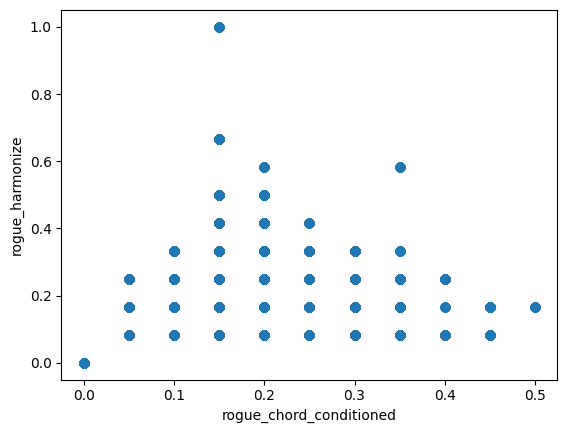

In [ ]:
# prompt: plot correlation between rogue_chord_conditioned and rogue_harmonize using matplotlib

import matplotlib.pyplot as plt

plt.scatter(filtered_source_pdf['rogue_chord_conditioned'], filtered_source_pdf['rogue_harmonize'])
plt.xlabel('rogue_chord_conditioned')
plt.ylabel('rogue_harmonize')
plt.show()

In [ ]:
# prompt: calculate correlation between rogue_chord_conditioned and rogue_harmonize

import pandas as pd

# Calculate the correlation between rogue_chord_conditioned and rogue_harmonize
correlation = filtered_source_pdf['rogue_chord_conditioned'].corr(filtered_source_pdf['rogue_harmonize'])

# Print the correlation
print(f"Correlation between rogue_chord_conditioned and rogue_harmonize: {correlation}")

Correlation between rogue_chord_conditioned and rogue_harmonize: 0.06879356814717134


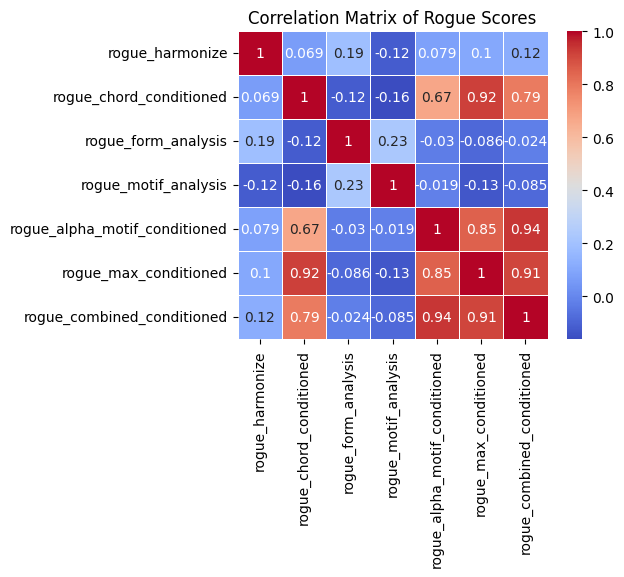

In [ ]:
# prompt: Display the correlation matrix between all the columns starting with "rogue_" using matplotlib and value written in each cell

import matplotlib.pyplot as plt
import seaborn as sns

# Get the columns starting with "rogue_"
rogue_columns = filtered_source_pdf.filter(like="rogue_").columns

# Calculate the correlation matrix
correlation_matrix = filtered_source_pdf[rogue_columns].corr()

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, cmap="coolwarm")
plt.title("Correlation Matrix of Rogue Scores")
plt.show()

In [ ]:
rogue_harmonize_validation = rogue_harmonize.sample(n=100)
rogue_motif_analysis_validation = rogue_motif_analysis.sample(n=350)
rogue_form_analysis_validation = rogue_form_analysis.sample(n=350)
rogue_alpha_motif_conditioned_validation = rogue_alpha_motif_conditioned.sample(n=350)
rogue_chord_conditioned_validation = rogue_chord_conditioned.sample(n=350)

In [ ]:
# prompt: append rogue_harmonize_validation & rogue_chord_conditioned_validation and drop duplicates

validationset = pd.concat([rogue_harmonize_validation, rogue_motif_analysis_validation, rogue_form_analysis_validation, rogue_alpha_motif_conditioned_validation, rogue_chord_conditioned_validation])
validationset = validationset.drop_duplicates()
len(validationset)

1500

In [ ]:
rogue_harmonize_train = rogue_harmonize.sample(n=2000)
rogue_motif_analysis_train = rogue_motif_analysis.sample(n=5000)
rogue_form_analysis_train = rogue_form_analysis.sample(n=5000)
rogue_alpha_motif_conditioned_train = rogue_alpha_motif_conditioned.sample(n=5000)
rogue_chord_conditioned_train = rogue_chord_conditioned.sample(n=5000)

In [ ]:
print(len(rogue_harmonize))
print(len(rogue_motif_analysis))
print(len(rogue_form_analysis))
print(len(rogue_alpha_motif_conditioned))
print(len(rogue_chord_conditioned))

2000
50000
13000
20000
10000


In [ ]:
# trainset = pd.concat([rogue_harmonize, rogue_chord_conditioned])
trainset = pd.concat([rogue_harmonize_train, rogue_motif_analysis_train, rogue_form_analysis_train, rogue_alpha_motif_conditioned_train, rogue_chord_conditioned_train])
trainset = trainset.drop_duplicates()
len(trainset)

22000

In [ ]:
# oversampled_trainset = pd.concat([oversampled_rogue_harmonize, oversampled_rogue_chord_conditioned]).sample(n=2500)
# oversampled_trainset = oversampled_trainset.drop_duplicates()
# len(oversampled_trainset)

In [ ]:
# trainset = pd.concat([trainset, oversampled_trainset])
# trainset = trainset.drop_duplicates()
# len(trainset)

In [ ]:
# prompt: remove rows in validationset from trainset

trainset = trainset.merge(validationset, how='outer', indicator=True)
trainset.groupby('_merge').count()

,instruction,input,output,src,id,rogue_harmonize,rogue_chord_conditioned,rogue_form_analysis,rogue_motif_analysis,rogue_alpha_motif_conditioned,rogue_max_conditioned,rogue_combined_conditioned
_merge,,,,,,,,,,,,
left_only,21475,21475,21475,21475,21475,21475,21475,21475,21475,21475,16614,16614
right_only,975,975,975,975,975,975,975,975,975,975,764,764
both,525,525,525,525,525,525,525,525,525,525,386,386


In [ ]:
trainset = trainset[trainset['_merge'] == 'left_only']

In [ ]:
trainset = trainset.drop('_merge', axis=1)
len(trainset)

21475

In [ ]:
# prompt: shuffle trainset

trainset = trainset.sample(frac=1).reset_index(drop=True)
trainset

,instruction,input,output,src,id,rogue_harmonize,rogue_chord_conditioned,rogue_form_analysis,rogue_motif_analysis,rogue_alpha_motif_conditioned,rogue_max_conditioned,rogue_combined_conditioned
0,Investigate the complexities of this piece of music and provide a detailed analysis of its structural aspects using relevant music theory concepts.,"X:1\nL:1/8\nQ:1/4=320\nM:4/4\nK:G\n""^A""""^d"" (3cBc BA""^f#"" ^GA Bc |""^d"" z A2""^f#"" c<c c B<A |""^g"" ^G/A/ z3 cccB | B2 D2 =FG ^G2 | \n""^d"" z A2 z""^f#"" B z =G z |""^e"" E2 A z""^g#"" G z D2 |""^a"" ^A/G/^F/E/ FE E z D z | \n""^e"" ^F z GA""^a"" z2 B2 |""^d"" cc BA""^f#"" ^GA c z |""^d"" .B2 .G2""^f#"" .F2 .A2 |""^g"" F2 e z d z c z | \n""^e"" B z D z""^g"" FG ^GA |""^g"" A z ^c z B z F2 |""^a"" A z G2 F z G2 |""^a"" F/=F/ Ee ^cA z3 | \n""^d"" (3CB,C B,A,""F#"" ^G,A, B,C |""^d"" z A,2""F#"" C<C C B,<A, |""^g"" ^G,/A,/ z3 CCCB, | \n B,2 D,2 =F,G, ^G,2 |""^d"" z A,2 z""F#"" B, z =G, z |""^e"" E,2 A, z""G#"" G, z D,2 | \n""^a"" ^A,/G,/^F,/E,/ F,E, E, z D, z |""^e"" ^F, z G,A,""A"" z2 B,2 |""^d"" CC B,A,""F#"" ^G,A, C z | \n""^d"" .B,2 .G,2""F#"" .F,2 .A,2 |""^g"" F,2 E z D z C z |""^e"" B, z D, z""G"" F,G, ^G,A, | \n""^g"" A, z ^C z B, z F,2 |""^a"" A, z G,2 F, z G,2 |""^a"" F,/=F,/ E,E ^CA, z3 |: \n[M:2/4][K:D]""^B""""^a"" z E/D/ ^D=D | (3.C2 .C2 .C2 | C z C2 | .C2 .A2 | .C2 DF | FE z2 | F/E/F z2 | \n (3.G2 .G2 .F2 | EE D2 | c ^A =A A | (3GFG z ^A | A2 G2 | z F A2 | G z D2 | ^G =G F E | =F E ^F z | \n G z A z |""^g"" (3BAB z B | .B2 .B2 | .B2 .B2 | .B2 .B2 | B ^d c z | A z B2 |""^d"" G2 A2 | \n""^g"" F G z G |""^e"" E E F z |""^g"" .D2 .D2 |""^g"" F z A G |""^g"" F z GG |""^a"" F E E z :| \n[M:4/4][K:G]""^C""""^a"" ^c2 =c2""^g"" B2 B2 |""^g"" B2 B2""^d"" B2 B2 |""^g"" B2 B2 (3B2 c2 c2 | \n""^g"" A2 B2""^d"" G2 A2 |""^g"" (3F2 G2 F2""^e"" E E3 |""^g#"" F3 D""^f#"" F2 AG |""^g#"" F2 E2""^a"" E4 | \n""^a"" z3 ^C""^d"" A2 B2 |""^a"" c2 ^c2 d2 B2 |""^g"" B2 B2 B2 B2 |""^a"" B2 B2""^g"" B2 =cc | \n""^g"" A2 B2""^d"" G2 A2 |""^g"" (3F2 A2 G2""^e"" (3E2 F2 F2 |""^g#"" A2 d2""^g"" F z2 G | \n""^g"" F2 G2""^a"" F<E E2 |:[M:4/4][K:A]""^D"" z4 z z/ F/ =FF |""^a"" EzE>d dcd<c |""^a"" c z c2 dc =cB | \n""^e"" B z B2""^g#"" ^cB ^A=A |""^a"" A z E2 AB AB | (3=fdc dc z c z/ A3/2 |""^e"" B/ z3/2 B2""^g#"" B G2 d | \n""^a"" cB ^A=A A E3 |""^e"" A z G2""^g#"" FD/ =F2 E/ |""^a"" z4 (3=ded (3dBB |""^e"" z4""^g#"" =c/d/^c (3B=cB | \n""^a"" z4 (3=c^cB ^A=A |""^a"" z4 AB AB |""^a"" ddcc z2 A2 |""^e"" BA B2""^g#"" B z G2 | cBAA z z/ F/ =FF :|",Sectional: Through Composed,https://huggingface.co/datasets/sander-wood/irishman,150053,0.166667,0.15,0.333333,0.136364,0.166667,NaN,NaN
1,Inspect the qualities of this musical work and delineate its arrangement using music-specific terms.,X:1\nL:1/16\nM:4/4\nK:G\n G3 D E3 D G4 D3 D | G3 A{GA} B2 G2 B2 A2 A3 B | G3 D E2 D2 G4 D4 | G3 A B2 B2 B2 B2 B3 B | \n A3 G A2 B2 e4 e2 g2 | d3 e{e} d2 (cB) e2 A2 A3 B | G3 D E2 D2 G4 D3 D | e3 d e2 (dB) d3 B A3 B | \n G3 D E2 D2 G4 D4 |],Only One Section,https://huggingface.co/datasets/sander-wood/irishman,559440,0.250000,0.15,0.370370,0.181818,0.066667,NaN,NaN
2,Compose a musical piece using the specified sequence's alphabetical representation and the provided motif.,"AA';X:1\nL:1/8\nM:6/8\nK:D\n['D DFE EFE DFA AFA BAB', 'fed faf ede fdB AFA']",X:1\nL:1/8\nM:6/8\nK:D\n D | DFE EFE | DFA AFA | BAB def | gfg e2 D | DFE EFE | DFA AFA | BAB d2 e | fdd d2 :| g | \n fed faf | ede fdB | AFA def | gfg e2 a/g/ | fed faf | ede fdB | AFA d2 e | fdd d2 :|,https://huggingface.co/datasets/sander-wood/irishman,186406,0.166667,0.25,0.148148,0.181818,0.300000,0.300000,0.243902
3,Scrutinize the components of this musical work and discern its form with the help of music theory terms.,X:1\nL:1/8\nM:2/4\nK:G\n d | B>GGD | EFGA | BdBG | d/e/dzd | B>GGD | EFGA | BdBG | d/e/dzd | e/d/c/c/c/B/A/G/ | \n F/G/F/E/Dd | B/c/d/B/G/A/B/c/ | B2 AB | G2 z |],Only One Section,https://huggingface.co/datasets/sander-wood/irishman,862232,0.250000,0.10,0.370370,0.181

In [ ]:
# from sklearn.model_selection import train_test_split

# # validation file size should be lesser than 1 mb
# trainset, validationset = train_test_split(filtered_source_pdf, test_size=0.003, stratify=filtered_source_pdf['src'], random_state=42)

# print("Trainset size:", len(trainset))
# print("Validationset size:", len(validationset))


In [ ]:
trainset.groupby("src").count()

,instruction,input,output,id,rogue_harmonize,rogue_chord_conditioned,rogue_form_analysis,rogue_motif_analysis,rogue_alpha_motif_conditioned,rogue_max_conditioned,rogue_combined_conditioned
src,,,,,,,,,,,
https://huggingface.co/datasets/sander-wood/irishman,21475,21475,21475,21475,21475,21475,21475,21475,21475,16614,16614


In [ ]:
validationset.groupby("src").count()

,instruction,input,output,id,rogue_harmonize,rogue_chord_conditioned,rogue_form_analysis,rogue_motif_analysis,rogue_alpha_motif_conditioned,rogue_max_conditioned,rogue_combined_conditioned
src,,,,,,,,,,,
https://huggingface.co/datasets/sander-wood/irishman,1500,1500,1500,1500,1500,1500,1500,1500,1500,1150,1150


In [ ]:
# prompt: Save in train and validation set in jsonl format like {"messages": [{"role": "user","content": "User interaction n°1 contained in document n°2"},{"role": "assistant","content": "Bot interaction n°1 contained in document n°2"},{"role": "user","content": "User interaction n°2 contained in document n°1"},{"role": "assistant","content": "Bot interaction n°2 contained in document n°1"}]}
import json

def convert_to_jsonl(dataset, filename):
  with open(filename, "w") as outfile:
    for _, example in dataset.iterrows():
      messages = []
      if example["instruction"] is not None and len(example["instruction"].strip()) > 0:
        messages.append({"role": "system", "content": example["instruction"]})
      if example["input"] is not None and len(example["input"].strip()) > 0:
        messages.append({"role": "user", "content": example["input"]})
      messages.append({"role": "assistant", "content": example["output"]})
      jsonl_example = {"messages": messages}
      jsonl_string = json.dumps(jsonl_example)
      outfile.write(jsonl_string + "\n")

convert_to_jsonl(trainset, "train.jsonl")
convert_to_jsonl(validationset, "validation.jsonl")


In [ ]:
!ls -ltrh

total 14M
drwxr-xr-x 1 root root 4.0K Jun 27 13:26 sample_data
drwx------ 6 root root 4.0K Jun 28 17:13 drive
-rw-r--r-- 1 root root  13M Jun 28 20:57 train.jsonl
-rw-r--r-- 1 root root 913K Jun 28 20:57 validation.jsonl


In [ ]:
!head -n1 train.jsonl

{"messages": [{"role": "system", "content": "Investigate the complexities of this piece of music and provide a detailed analysis of its structural aspects using relevant music theory concepts."}, {"role": "user", "content": "X:1\nL:1/8\nQ:1/4=320\nM:4/4\nK:G\n\"^A\"\"^d\" (3cBc BA\"^f#\" ^GA Bc |\"^d\" z A2\"^f#\" c<c c B<A |\"^g\" ^G/A/ z3 cccB | B2 D2 =FG ^G2 | \n\"^d\" z A2 z\"^f#\" B z =G z |\"^e\" E2 A z\"^g#\" G z D2 |\"^a\" ^A/G/^F/E/ FE E z D z | \n\"^e\" ^F z GA\"^a\" z2 B2 |\"^d\" cc BA\"^f#\" ^GA c z |\"^d\" .B2 .G2\"^f#\" .F2 .A2 |\"^g\" F2 e z d z c z | \n\"^e\" B z D z\"^g\" FG ^GA |\"^g\" A z ^c z B z F2 |\"^a\" A z G2 F z G2 |\"^a\" F/=F/ Ee ^cA z3 | \n\"^d\" (3CB,C B,A,\"F#\" ^G,A, B,C |\"^d\" z A,2\"F#\" C<C C B,<A, |\"^g\" ^G,/A,/ z3 CCCB, | \n B,2 D,2 =F,G, ^G,2 |\"^d\" z A,2 z\"F#\" B, z =G, z |\"^e\" E,2 A, z\"G#\" G, z D,2 | \n\"^a\" ^A,/G,/^F,/E,/ F,E, E, z D, z |\"^e\" ^F, z G,A,\"A\" z2 B,2 |\"^d\" CC B,A,\"F#\" ^G,A, C z | \n\"^d\" .B,2 .G,2\"F#\" .F,2 .A,2 |

In [ ]:
# CAUTION: Can override existing drive files

from google.colab import drive
drive.mount('/content/drive')

import shutil
shutil.copy("train.jsonl","/content/drive/MyDrive/mistral-ft/train_5_tasks.jsonl")
shutil.copy("validation.jsonl","/content/drive/MyDrive/mistral-ft/validation_5_tasks.jsonl")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/mistral-ft/validation_5_tasks.jsonl'

In [ ]:
# prompt: read jsonl file from drive

from google.colab import drive
import json

drive.mount('/content/drive')

train_data_loaded = []
with open('/content/drive/MyDrive/mistral-ft/train_5_tasks.jsonl', 'r') as f:
  for l in f.readlines():
        a = json.loads(l)
        train_data_loaded.append(a)

# Process the lines as needed.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# {
#     "messages": [
#         {
#             "role": "system",
#             "content": "Compose a musical piece that mirrors the style and essence of Bach's famous works."
#         },
#         {
#             "role": "user",
#             "content": ""
#         },
#         {
#             "role": "assistant",
#             "content": "X:1\nT:Music21 Fragment\nT:Music21 Fragment\nT:Music21\nC:Music21\n%%score 1 2 3 4\nL:1/4\nM:4/4\nK:C\nV:1 treble \n%%MIDI program 0\n%%MIDI control 7 100\n%%MIDI control 10 64\nV:2 treble \n%%MIDI program 0\n%%MIDI control 7 100\n%%MIDI control 10 64\nL:1/8\nV:3 bass \n%%MIDI program 0\n%%MIDI control 7 100\n%%MIDI control 10 64\nV:4 bass \n%%MIDI program 0\n%%MIDI control 7 100\n%%MIDI control 10 64\nV:1\n z3 A, | C D !fermata!E F | E D G F | !fermata!E2 z A | G F E D | C D C _B, | !fermata!A,2 z E | %7\n F G !fermata!A A | G D/E/ F E | !fermata!D3 z |] %10\nV:2\n z6 A,2 | E, C2 B, !fermata!C2 A,B, | ^C2 D2 D E2 D | !fermata!^C4 z2 F2 | F E2 D2 C2 _B, | %5\n _B,A, B,A, G,F, G,E, | !fermata!F,4 z2 G,2 | A,C DE !fermata!F2 DC | _B,C D2 D3 ^C | %9\n !fermata!A,6 z2 |] %10\nV:3\n z3 D, | C,/E,/ A,/G,/ !fermata!G, D, | E,/4F,/4 G, F,/4E,/4 D,/A,/ A, | !fermata!A,2 z =C | %4\n C/>_B,/ A, A,/>G,/ F, | F, F, C,2 | !fermata!C,2 z C, | C _B, !fermata!C A, | D, G, A, A,/G,/ | %9\n !fermata!^F,3 z |] %10\nV:4\n z3\"Dpower\" D,, |\"Am\" A,,\"Dm7/F\" F,,/G,,/\"C\" !fermata!C,\"Dm\" D, |\"A\" A,,\"G/B\" B,,3/2 ^C,/\"Dm\" D, | %3\n\"A\" !fermata!A,,2 z\"F\" F,, |\"Csus4\" C,\"Dm\" D,\"Asus4\" A,,\"Bb\" _B,, | %5\n\"Fsus4\" F,,/E,,/\"Bb/D\" D,,\"C/E\" E,,/D,,/\"C7/E\" E,,/C,,/ |\"F\" !fermata!F,,2 z\"C\" C,/_B,,/ | %7\n\"F/A\" A,,\"Gm\" G,,\"F\" !fermata!F,,\"D/F#\" ^F,, |\"Gm\" G,,/A,,/\"Gm/Bb\" _B,,\"Dm/F\" F,,/G,,/\"Asus4\" A,, | %9\n\"D\" !fermata!D,,3 z |] %10"
#         }
#     ]
# }

for obj in train_data_loaded:
    for message in obj['messages']:
        # if empty content print it
        if message['content'] == '':
            print(message)

In [ ]:
import os
from mistralai.client import MistralClient
from google.colab import userdata


api_key = userdata.get('MISTRAL_API_KEY')
client = MistralClient(api_key=api_key)

In [ ]:
# ??client.files.create

In [ ]:
training_data = None
validation_data = None

with open('/content/drive/MyDrive/mistral-ft/train_5_tasks.jsonl', "rb") as f:
    training_data = client.files.create(file=("train_5_tasks.jsonl", f), purpose="fine-tune")

with open('/content/drive/MyDrive/mistral-ft/validation_5_tasks.jsonl', "rb") as f:
    validation_data = client.files.create(file=("validation_5_tasks.jsonl", f), purpose="fine-tune")


In [ ]:
training_data

FileObject(id='50feac31-a1cb-4f32-bab8-4b01a2f01050', object='file', bytes=13741439, created_at=1719608241, filename='train_5_tasks.jsonl', purpose='fine-tune')

In [ ]:
from mistralai.models.jobs import WandbIntegrationIn, TrainingParameters

wandb_api_key = userdata.get('WANDB_API_KEY')

created_jobs = client.jobs.create(
    model="open-mistral-7b",
    training_files=[training_data.id],
    validation_files=[validation_data.id],
    hyperparameters=TrainingParameters(
        training_steps=150,
        learning_rate=0.0001,
    ),
    integrations=[
        WandbIntegrationIn(
            project="mistral-ft",
            run_name="test",
            api_key=wandb_api_key,
        ).dict()
    ],
    # dry_run=True
)

In [ ]:
# ??TrainingParameters

In [ ]:
created_jobs

Job(id='c288eca8-4433-4a34-a0b6-55d4f0d69209', hyperparameters=TrainingParameters(training_steps=150, learning_rate=0.0001), fine_tuned_model=None, model='open-mistral-7b', status='QUEUED', job_type='FT', created_at=1719608802, modified_at=1719608802, training_files=['50feac31-a1cb-4f32-bab8-4b01a2f01050'], validation_files=['db750863-907e-499c-9396-f667d6e09fa4'], object='job', integrations=[WandbIntegration(type='wandb', project='mistral-ft', name=None, run_name='test')])

In [ ]:
# List jobs
jobs = client.jobs.list()
print(jobs)

# Retrieve a jobs
retrieved_jobs = client.jobs.retrieve(created_jobs.id)
print(retrieved_jobs)

data=[Job(id='c288eca8-4433-4a34-a0b6-55d4f0d69209', hyperparameters=TrainingParameters(training_steps=150, learning_rate=0.0001), fine_tuned_model=None, model='open-mistral-7b', status='RUNNING', job_type='FT', created_at=1719608802, modified_at=1719608804, training_files=['50feac31-a1cb-4f32-bab8-4b01a2f01050'], validation_files=['db750863-907e-499c-9396-f667d6e09fa4'], object='job', integrations=[WandbIntegration(type='wandb', project='mistral-ft', name=None, run_name='test')])] object='list'
id='c288eca8-4433-4a34-a0b6-55d4f0d69209' hyperparameters=TrainingParameters(training_steps=150, learning_rate=0.0001) fine_tuned_model=None model='open-mistral-7b' status='RUNNING' job_type='FT' created_at=1719608802 modified_at=1719608804 training_files=['50feac31-a1cb-4f32-bab8-4b01a2f01050'] validation_files=['db750863-907e-499c-9396-f667d6e09fa4'] object='job' integrations=[WandbIntegration(type='wandb', project='mistral-ft', name=None, run_name='test')] events=[Event(name='status-updated'

In [ ]:
for m in client.list_models().data:
    print(m)

id='open-mistral-7b' object='model' created=1719609384 owned_by='mistralai' root=None parent=None permission=[ModelPermission(id='modelperm-45ec256fd1f44a399f286b82361142bc', object='model_permission', created=1719609384, allow_create_engine=False, allow_sampling=True, allow_logprobs=False, allow_search_indices=False, allow_view=True, allow_fine_tuning=False, organization='*', group=None, is_blocking=False)]
id='mistral-tiny-2312' object='model' created=1719609384 owned_by='mistralai' root=None parent=None permission=[ModelPermission(id='modelperm-020e11799a444b0dbc5810d203ef958a', object='model_permission', created=1719609384, allow_create_engine=False, allow_sampling=True, allow_logprobs=False, allow_search_indices=False, allow_view=True, allow_fine_tuning=False, organization='*', group=None, is_blocking=False)]
id='mistral-tiny' object='model' created=1719609384 owned_by='mistralai' root=None parent=None permission=[ModelPermission(id='modelperm-a5c44f3ccd1a411a9524a9fffb8916c1', ob

In [ ]:
for f in client.files.list():
    print(f)

('data', [FileObject(id='ed1a0cf3-502d-4e8e-9326-9da305a941ed', object='file', bytes=1155693, created_at=1719607732, filename='validation_5_tasks.jsonl', purpose='fine-tune'), FileObject(id='3bace7d3-d1e5-49f6-a458-c9c6a9b9f484', object='file', bytes=13607582, created_at=1719607731, filename='train_5_tasks.jsonl', purpose='fine-tune')])
('object', 'list')


# Dataset Validation

In [ ]:
!git clone https://github.com/mistralai/mistral-finetune.git

Cloning into 'mistral-finetune'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 401 (delta 125), reused 94 (delta 94), pack-reused 259
Receiving objects: 100% (401/401), 210.17 KiB | 6.37 MiB/s, done.
Resolving deltas: 100% (209/209), done.


In [ ]:
!pip install -r mistral-finetune/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.9/704.9 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.2/218.2 MB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu

In [ ]:
!touch mistral-finetune/__init__.py

In [ ]:
!chmod 777 mistral-finetune/__init__.py

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.1/296.1 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


modify example/7B.yaml
```
# data
data:
  instruct_data: "../train.jsonl"  # Fill
  data: ""  # Optionally fill with pretraining data
  eval_instruct_data: "../validation.jsonl"  # Optionally fill

# model
model_id_or_path: "open-mistral-7b"  # Change to downloaded path
lora:
  rank: 64

# optim
seq_len: 32768
batch_size: 1
max_steps: 1
optim:
  lr: 6.e-5
  weight_decay: 0.1
  pct_start: 0.05

# other
seed: 0
log_freq: 1
eval_freq: 100
no_eval: False
ckpt_freq: 100

save_adapters: True  # save only trained LoRA adapters. Set to `False` to merge LoRA adapter into the base model and save full fine-tuned model

run_dir: "./"  # Fill

wandb:
  project: "mistral-ft" # your wandb project name
  run_name: "trial" # your wandb run name
  key: "<fill-this>" # your wandb api key
  offline: False
```

In validate_data.py

```
import sys

sys.path.append(".")
```

In [ ]:
!cd mistral-finetune && python utils/validate_data.py --train_yaml example/7B.yaml &> out.txt

/bin/bash: line 1: cd: mistral-finetune: No such file or directory


In [ ]:
!ls mistral-finetune/utils

extend_model_vocab.py  merge_lora.py		reformat_data.py
__init__.py	       reformat_data_glaive.py	validate_data.py


# Debug jsonl format

In [ ]:
train_data_loaded = []
with open("train.jsonl", "r") as f:
    for l in f.readlines():
        a = json.loads(l)
        train_data_loaded.append(a)

In [ ]:
trainset[trainset.instruction.str.contains("The title is KREIS KREIS KESSEL. It belongs to the genres of")]

,instruction,input,output,src,id
396606,"Generate a piece of music. The title is KREIS KREIS KESSEL. It belongs to the genres of ""Kinder - Lied"""" Reigen""and "" Tanz - Spiel"". It is from Europa, Mitteleuropa, Deutschland, Erfurt. Its meter type is simple duple.",,"X:1\nT:KREIS KREIS KESSEL\nT:KREIS KREIS KESSEL\nL:1/8\nM:2/4\nI:linebreak $\nK:G\nV:1 treble nm=""Voice"" snm=""V""\nV:1\n G2 B2 | d2 B2 | GA Bc | d2 B2 | dd BG | ee d2 | cc BB | AA G2 || %8",http://kern.ccarh.org,396606
731082,"Generate a piece of music. The title is KREIS KREIS KESSEL. It belongs to the genres of ""Kinder - Lied"""" Reigen""and "" Tanz - Spiel"". It is from Europa, Mitteleuropa, Deutschland, Weimar. Its meter type is simple duple.",,"X:1\nT:KREIS KREIS KESSEL\nT:KREIS KREIS KESSEL\nL:1/8\nM:2/4\nI:linebreak $\nK:F\nV:1 treble nm=""Voice"" snm=""V""\nV:1\n c2 d2 | c2 A z | cc dd | c2 A z | BB GG | cc A2 | d>c BA | GG F2 || %8",http://kern.ccarh.org,731082


In [ ]:
with open('/content/drive/MyDrive/mistral-ft/train.jsonl', 'r') as f:
    lines = f.readlines()
    print(lines[188676])

{"messages": [{"role": "system", "content": "Create musical compositions employing the designated chord progressions."}, {"role": "user", "content": "'G', 'D7', 'G', 'C', 'G', 'D7', 'G', 'G', 'D7', 'G', 'C', 'G', 'D7', 'G'"}, {"role": "assistant", "content": "X:1\nL:1/8\nM:2/4\nK:G\n B>A |\"G\" GD B,D | G3 G |\"D7\" AA AA | A3 A |\"G\" BB BB/B/ |\"C\" cc/c/ cc/c/ |\"G\" BG\"D7\" AF | \n\"G\" G2 z || B2 |\"G\" GG/G/ GG/G/ | G3 G |\"D7\" AA/A/ AA/A/ | A3 A |\"G\" BB/B/ BB |\"C\" cc cc/c/ | \n\"G\" BG\"D7\" AF |\"G\" G2 |]"}]}



In [ ]:
with open('/content/drive/MyDrive/mistral-ft/train.jsonl', 'r') as f:
    lines = f.readlines()
    print(lines[188676][530+1])

IndexError: string index out of range

In [ ]:
with open("train.jsonl", "r") as f:
    with open("train_new.jsonl", "w") as w:
        i = 0
        for l in f.readlines():
            i+=1
            if i != 19010 and i!=52227 and i!=345484:
                w.write(l)